In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  8%|█████                                                         | 4089/50000 [00:00<00:01, 40883.41it/s]

 16%|██████████▏                                                   | 8219/50000 [00:00<00:01, 41125.47it/s]

 25%|███████████████▍                                             | 12698/50000 [00:00<00:00, 42793.96it/s]

 34%|████████████████████▉                                        | 17169/50000 [00:00<00:00, 43549.79it/s]

 43%|██████████████████████████▎                                  | 21524/50000 [00:00<00:00, 43526.57it/s]

 52%|███████████████████████████████▋                             | 25992/50000 [00:00<00:00, 43916.06it/s]

 61%|█████████████████████████████████████                        | 30410/50000 [00:00<00:00, 44000.25it/s]

 70%|██████████████████████████████████████████▍                  | 34811/50000 [00:00<00:00, 43028.12it/s]

 79%|███████████████████████████████████████████████▉             | 39265/50000 [00:00<00:00, 43492.29it/s]

 87%|█████████████████████████████████████████████████████▏       | 43618/50000 [00:01<00:00, 42744.55it/s]

 96%|██████████████████████████████████████████████████████████▌  | 47974/50000 [00:01<00:00, 42988.31it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43143.72it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 43%|██████████████████████████▋                                   | 4311/10000 [00:00<00:00, 43107.99it/s]

 86%|█████████████████████████████████████████████████████▍        | 8622/10000 [00:00<00:00, 41807.84it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41754.93it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 5izbkda2


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-5izbkda2:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/313 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/313 [00:00<02:38,  1.97it/s]

  2%|█▌                                                                    | 7/313 [00:00<00:21, 14.28it/s]

  4%|██▊                                                                  | 13/313 [00:00<00:12, 24.14it/s]

  6%|████▍                                                                | 20/313 [00:00<00:08, 34.65it/s]

  9%|█████▉                                                               | 27/313 [00:00<00:06, 42.78it/s]

 11%|███████▍                                                             | 34/313 [00:01<00:05, 48.84it/s]

 13%|█████████                                                            | 41/313 [00:01<00:05, 53.30it/s]

 15%|██████████▌                                                          | 48/313 [00:01<00:04, 56.57it/s]

 18%|████████████                                                         | 55/313 [00:01<00:04, 58.91it/s]

 20%|█████████████▋                                                       | 62/313 [00:01<00:04, 60.59it/s]

 22%|███████████████▏                                                     | 69/313 [00:01<00:03, 61.80it/s]

 24%|████████████████▊                                                    | 76/313 [00:01<00:03, 62.64it/s]

 27%|██████████████████▎                                                  | 83/313 [00:01<00:03, 63.23it/s]

 29%|███████████████████▊                                                 | 90/313 [00:01<00:03, 63.66it/s]

 31%|█████████████████████▍                                               | 97/313 [00:02<00:03, 63.97it/s]

 33%|██████████████████████▌                                             | 104/313 [00:02<00:03, 64.20it/s]

 35%|████████████████████████                                            | 111/313 [00:02<00:03, 64.33it/s]

 38%|█████████████████████████▋                                          | 118/313 [00:02<00:03, 64.45it/s]

 40%|███████████████████████████▏                                        | 125/313 [00:02<00:02, 64.50it/s]

 42%|████████████████████████████▋                                       | 132/313 [00:02<00:02, 64.58it/s]

 44%|██████████████████████████████▏                                     | 139/313 [00:02<00:02, 64.60it/s]

 47%|███████████████████████████████▋                                    | 146/313 [00:02<00:02, 64.37it/s]

 49%|█████████████████████████████████▏                                  | 153/313 [00:02<00:02, 64.42it/s]

 51%|██████████████████████████████████▊                                 | 160/313 [00:03<00:02, 64.45it/s]

 53%|████████████████████████████████████▎                               | 167/313 [00:03<00:02, 64.46it/s]

 56%|█████████████████████████████████████▊                              | 174/313 [00:03<00:02, 64.45it/s]

 58%|███████████████████████████████████████▎                            | 181/313 [00:03<00:02, 64.46it/s]

 60%|████████████████████████████████████████▊                           | 188/313 [00:03<00:01, 64.44it/s]

 62%|██████████████████████████████████████████▎                         | 195/313 [00:03<00:01, 64.46it/s]

 65%|███████████████████████████████████████████▉                        | 202/313 [00:03<00:01, 64.43it/s]

 67%|█████████████████████████████████████████████▍                      | 209/313 [00:03<00:01, 64.45it/s]

 69%|██████████████████████████████████████████████▉                     | 216/313 [00:03<00:01, 64.46it/s]

 71%|████████████████████████████████████████████████▍                   | 223/313 [00:03<00:01, 64.45it/s]

 73%|█████████████████████████████████████████████████▉                  | 230/313 [00:04<00:01, 64.49it/s]

 76%|███████████████████████████████████████████████████▍                | 237/313 [00:04<00:01, 64.56it/s]

 78%|█████████████████████████████████████████████████████               | 244/313 [00:04<00:01, 64.61it/s]

 80%|██████████████████████████████████████████████████████▌             | 251/313 [00:04<00:00, 64.60it/s]

 82%|████████████████████████████████████████████████████████            | 258/313 [00:04<00:00, 64.63it/s]

 85%|█████████████████████████████████████████████████████████▌          | 265/313 [00:04<00:00, 64.66it/s]

 87%|███████████████████████████████████████████████████████████         | 272/313 [00:04<00:00, 64.67it/s]

 89%|████████████████████████████████████████████████████████████▌       | 279/313 [00:04<00:00, 64.68it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 286/313 [00:04<00:00, 64.68it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 293/313 [00:05<00:00, 64.70it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 300/313 [00:05<00:00, 64.71it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 307/313 [00:05<00:00, 64.62it/s]

100%|████████████████████████████████████████████████████████████████████| 313/313 [00:05<00:00, 57.63it/s]

train - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  4%|██▋                                                                    | 3/79 [00:00<00:02, 27.63it/s]

 13%|████████▊                                                             | 10/79 [00:00<00:01, 49.09it/s]

 22%|███████████████                                                       | 17/79 [00:00<00:01, 56.05it/s]

 30%|█████████████████████▎                                                | 24/79 [00:00<00:00, 59.35it/s]

 39%|███████████████████████████▍                                          | 31/79 [00:00<00:00, 61.20it/s]

 48%|█████████████████████████████████▋                                    | 38/79 [00:00<00:00, 62.30it/s]

 57%|███████████████████████████████████████▊                              | 45/79 [00:00<00:00, 63.03it/s]

 66%|██████████████████████████████████████████████                        | 52/79 [00:00<00:00, 63.48it/s]

 75%|████████████████████████████████████████████████████▎                 | 59/79 [00:00<00:00, 63.75it/s]

 84%|██████████████████████████████████████████████████████████▍           | 66/79 [00:01<00:00, 63.99it/s]

 92%|████████████████████████████████████████████████████████████████▋     | 73/79 [00:01<00:00, 64.16it/s]

100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.69it/s]

val - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  3%|█▊                                                                     | 2/79 [00:00<00:03, 19.97it/s]

 11%|████████                                                               | 9/79 [00:00<00:01, 46.93it/s]

 20%|██████████████▏                                                       | 16/79 [00:00<00:01, 55.15it/s]

 29%|████████████████████▍                                                 | 23/79 [00:00<00:00, 58.94it/s]

 38%|██████████████████████████▌                                           | 30/79 [00:00<00:00, 60.83it/s]

 47%|████████████████████████████████▊                                     | 37/79 [00:00<00:00, 62.15it/s]

 56%|██████████████████████████████████████▉                               | 44/79 [00:00<00:00, 62.98it/s]

 65%|█████████████████████████████████████████████▏                        | 51/79 [00:00<00:00, 63.52it/s]

 73%|███████████████████████████████████████████████████▍                  | 58/79 [00:00<00:00, 63.88it/s]

 82%|█████████████████████████████████████████████████████████▌            | 65/79 [00:01<00:00, 64.14it/s]

 91%|███████████████████████████████████████████████████████████████▊      | 72/79 [00:01<00:00, 64.31it/s]

100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.15it/s]

100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.20it/s]

test InD - OK


  0%|                                                                              | 0/469 [00:00<?, ?it/s]

  0%|▎                                                                     | 2/469 [00:00<00:23, 19.52it/s]

  2%|█▎                                                                    | 9/469 [00:00<00:09, 46.49it/s]

  3%|██▎                                                                  | 16/469 [00:00<00:08, 54.86it/s]

  5%|███▍                                                                 | 23/469 [00:00<00:07, 58.76it/s]

  6%|████▍                                                                | 30/469 [00:00<00:07, 60.90it/s]

  8%|█████▍                                                               | 37/469 [00:00<00:06, 62.19it/s]

  9%|██████▍                                                              | 44/469 [00:00<00:06, 63.00it/s]

 11%|███████▌                                                             | 51/469 [00:00<00:06, 63.54it/s]

 12%|████████▌                                                            | 58/469 [00:00<00:06, 63.86it/s]

 14%|█████████▌                                                           | 65/469 [00:01<00:06, 64.08it/s]

 15%|██████████▌                                                          | 72/469 [00:01<00:06, 64.23it/s]

 17%|███████████▌                                                         | 79/469 [00:01<00:06, 64.33it/s]

 18%|████████████▋                                                        | 86/469 [00:01<00:05, 64.36it/s]

 20%|█████████████▋                                                       | 93/469 [00:01<00:05, 64.44it/s]

 21%|██████████████▍                                                     | 100/469 [00:01<00:05, 64.46it/s]

 23%|███████████████▌                                                    | 107/469 [00:01<00:05, 64.48it/s]

 24%|████████████████▌                                                   | 114/469 [00:01<00:05, 64.52it/s]

 26%|█████████████████▌                                                  | 121/469 [00:01<00:05, 64.52it/s]

 27%|██████████████████▌                                                 | 128/469 [00:02<00:05, 64.55it/s]

 29%|███████████████████▌                                                | 135/469 [00:02<00:05, 64.57it/s]

 30%|████████████████████▌                                               | 142/469 [00:02<00:05, 64.56it/s]

 32%|█████████████████████▌                                              | 149/469 [00:02<00:04, 64.57it/s]

 33%|██████████████████████▌                                             | 156/469 [00:02<00:04, 64.57it/s]

 35%|███████████████████████▋                                            | 163/469 [00:02<00:04, 64.58it/s]

 36%|████████████████████████▋                                           | 170/469 [00:02<00:04, 64.58it/s]

 38%|█████████████████████████▋                                          | 177/469 [00:02<00:04, 64.51it/s]

 39%|██████████████████████████▋                                         | 184/469 [00:02<00:04, 64.54it/s]

 41%|███████████████████████████▋                                        | 191/469 [00:03<00:04, 64.54it/s]

 42%|████████████████████████████▋                                       | 198/469 [00:03<00:04, 64.51it/s]

 44%|█████████████████████████████▋                                      | 205/469 [00:03<00:04, 64.53it/s]

 45%|██████████████████████████████▋                                     | 212/469 [00:03<00:03, 64.55it/s]

 47%|███████████████████████████████▊                                    | 219/469 [00:03<00:03, 64.56it/s]

 48%|████████████████████████████████▊                                   | 226/469 [00:03<00:03, 64.54it/s]

 50%|█████████████████████████████████▊                                  | 233/469 [00:03<00:03, 64.56it/s]

 51%|██████████████████████████████████▊                                 | 240/469 [00:03<00:03, 64.56it/s]

 53%|███████████████████████████████████▊                                | 247/469 [00:03<00:03, 64.57it/s]

 54%|████████████████████████████████████▊                               | 254/469 [00:04<00:03, 64.53it/s]

 56%|█████████████████████████████████████▊                              | 261/469 [00:04<00:03, 64.56it/s]

 57%|██████████████████████████████████████▊                             | 268/469 [00:04<00:03, 64.56it/s]

 59%|███████████████████████████████████████▊                            | 275/469 [00:04<00:03, 64.55it/s]

 60%|████████████████████████████████████████▉                           | 282/469 [00:04<00:02, 64.48it/s]

 62%|█████████████████████████████████████████▉                          | 289/469 [00:04<00:02, 64.52it/s]

 63%|██████████████████████████████████████████▉                         | 296/469 [00:04<00:02, 64.54it/s]

 65%|███████████████████████████████████████████▉                        | 303/469 [00:04<00:02, 64.53it/s]

 66%|████████████████████████████████████████████▉                       | 310/469 [00:04<00:02, 64.55it/s]

 68%|█████████████████████████████████████████████▉                      | 317/469 [00:04<00:02, 64.58it/s]

 69%|██████████████████████████████████████████████▉                     | 324/469 [00:05<00:02, 64.64it/s]

 71%|███████████████████████████████████████████████▉                    | 331/469 [00:05<00:02, 64.68it/s]

 72%|█████████████████████████████████████████████████                   | 338/469 [00:05<00:02, 64.69it/s]

 74%|██████████████████████████████████████████████████                  | 345/469 [00:05<00:01, 64.72it/s]

 75%|███████████████████████████████████████████████████                 | 352/469 [00:05<00:01, 64.73it/s]

 77%|████████████████████████████████████████████████████                | 359/469 [00:05<00:01, 64.67it/s]

 78%|█████████████████████████████████████████████████████               | 366/469 [00:05<00:01, 64.70it/s]

 80%|██████████████████████████████████████████████████████              | 373/469 [00:05<00:01, 64.72it/s]

 81%|███████████████████████████████████████████████████████             | 380/469 [00:05<00:01, 64.71it/s]

 83%|████████████████████████████████████████████████████████            | 387/469 [00:06<00:01, 64.73it/s]

 84%|█████████████████████████████████████████████████████████▏          | 394/469 [00:06<00:01, 64.73it/s]

 86%|██████████████████████████████████████████████████████████▏         | 401/469 [00:06<00:01, 64.73it/s]

 87%|███████████████████████████████████████████████████████████▏        | 408/469 [00:06<00:00, 64.72it/s]

 88%|████████████████████████████████████████████████████████████▏       | 415/469 [00:06<00:00, 64.74it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 422/469 [00:06<00:00, 64.75it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 429/469 [00:06<00:00, 64.75it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 436/469 [00:06<00:00, 64.75it/s]

 94%|████████████████████████████████████████████████████████████████▏   | 443/469 [00:06<00:00, 64.74it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 450/469 [00:07<00:00, 64.74it/s]

 97%|██████████████████████████████████████████████████████████████████▎ | 457/469 [00:07<00:00, 64.68it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 464/469 [00:07<00:00, 64.68it/s]

100%|████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 63.45it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  7%|████▉                                                                 | 7/100 [00:00<00:01, 64.49it/s]

 14%|█████████▋                                                           | 14/100 [00:00<00:01, 64.58it/s]

 21%|██████████████▍                                                      | 21/100 [00:00<00:01, 64.58it/s]

 28%|███████████████████▎                                                 | 28/100 [00:00<00:01, 64.59it/s]

 35%|████████████████████████▏                                            | 35/100 [00:00<00:01, 64.61it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:00<00:00, 64.65it/s]

 49%|█████████████████████████████████▊                                   | 49/100 [00:00<00:00, 64.66it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:00<00:00, 64.68it/s]

 63%|███████████████████████████████████████████▍                         | 63/100 [00:00<00:00, 64.70it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:01<00:00, 64.67it/s]

 77%|█████████████████████████████████████████████████████▏               | 77/100 [00:01<00:00, 64.68it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:01<00:00, 64.67it/s]

 91%|██████████████████████████████████████████████████████████████▊      | 91/100 [00:01<00:00, 64.68it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:01<00:00, 64.68it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.64it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 3, 32, 32) (30000, 512) (30000, 5) (30000,)
(6400, 3, 32, 32) (6400, 3, 32, 32) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


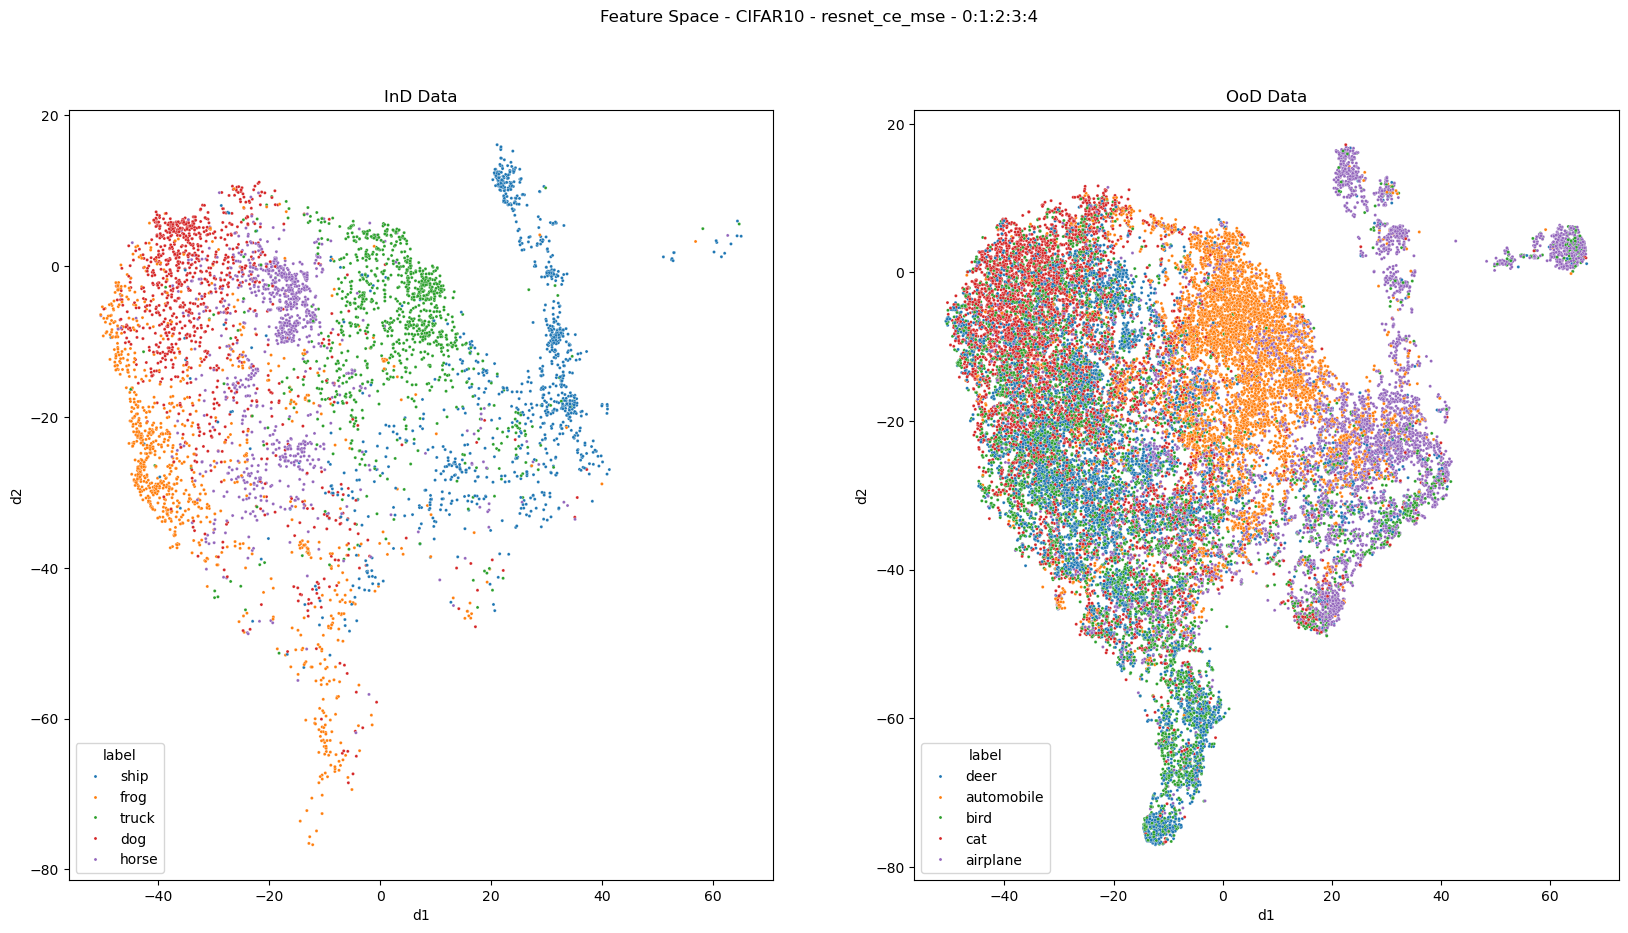

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

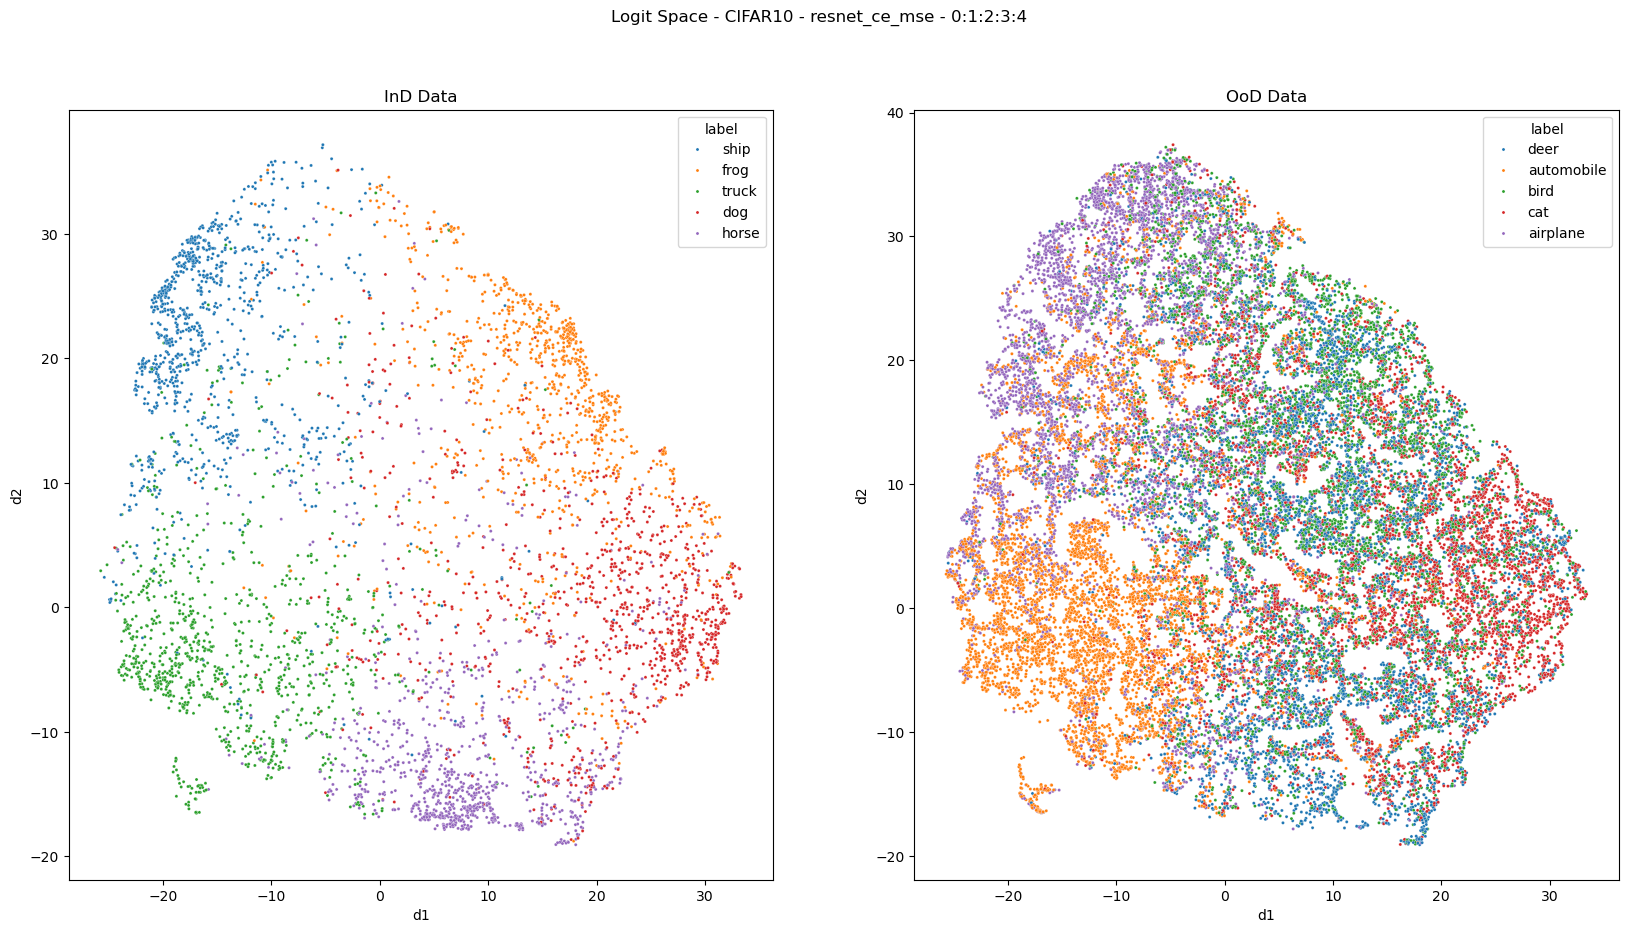

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:04,  1.39s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:03,  1.51s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:04<00:01,  1.51s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/it]

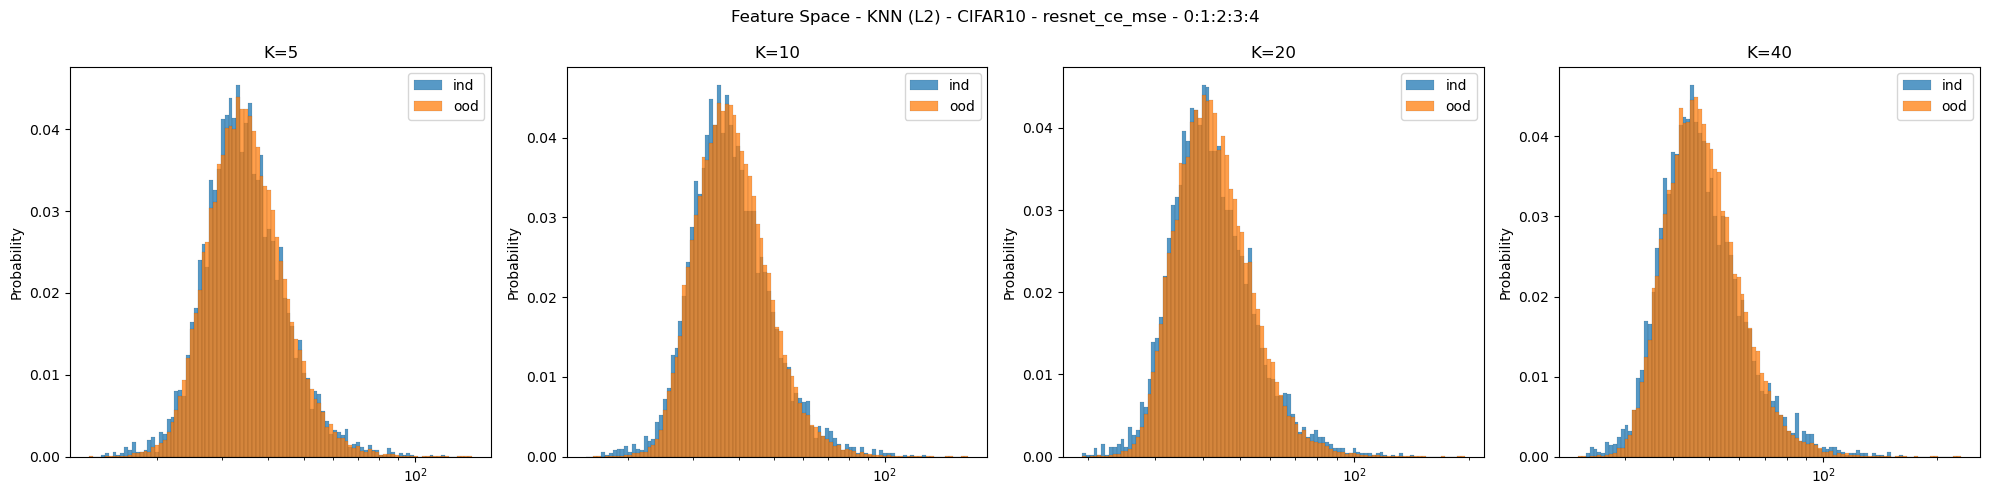

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:04,  1.35s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.38s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:04<00:01,  1.42s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.56s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.50s/it]

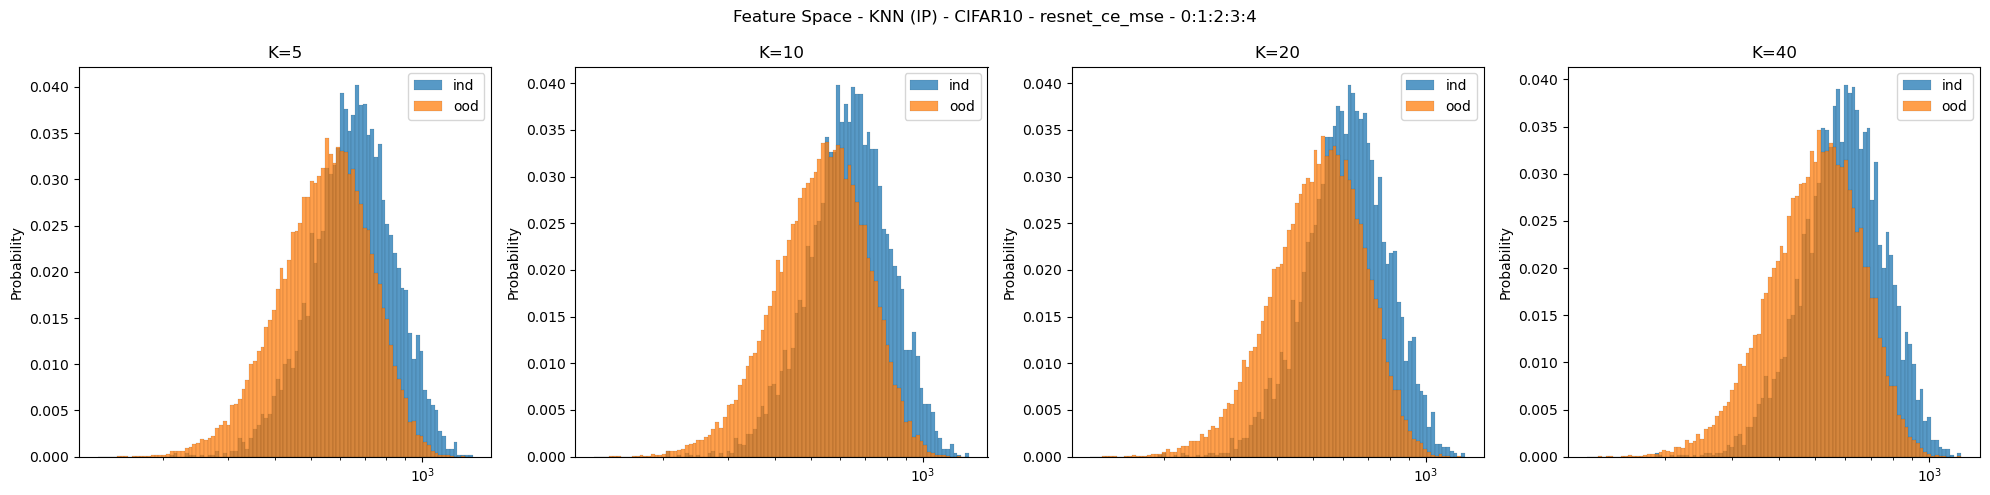

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  3.16it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.97it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.64it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]

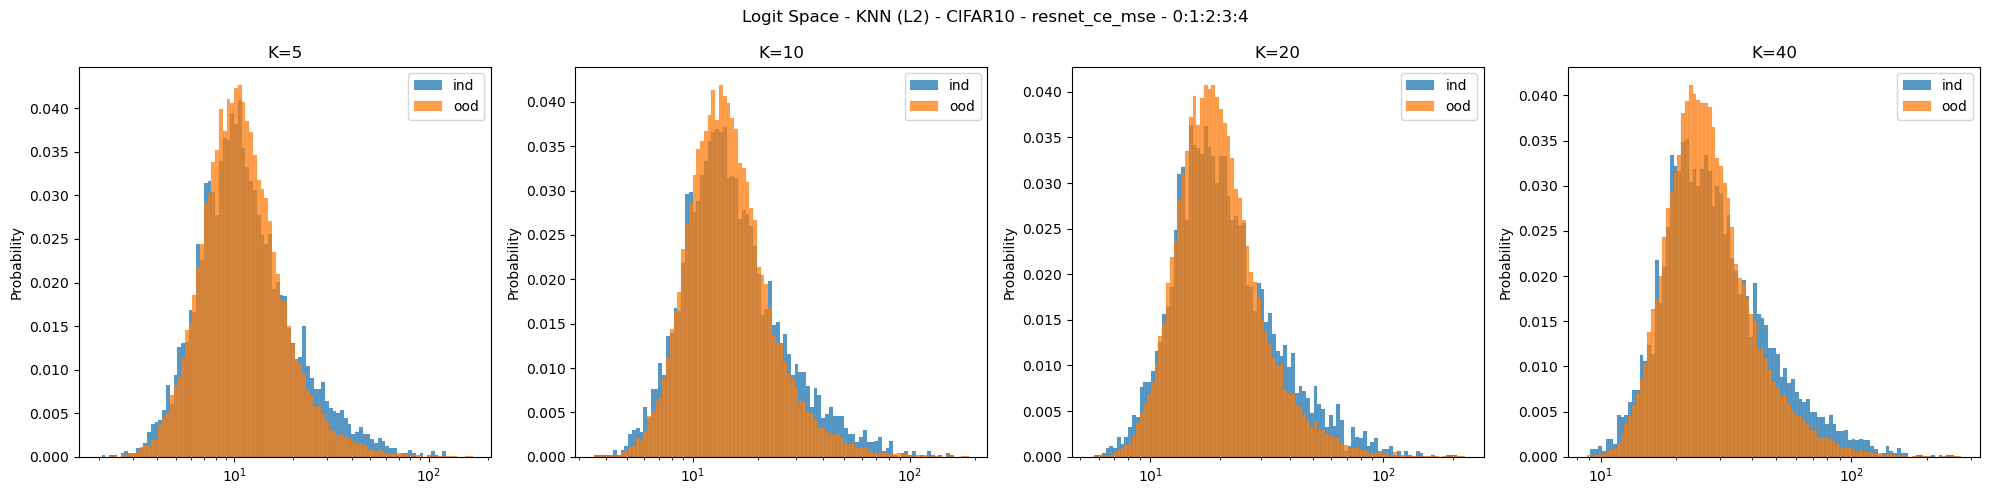

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  3.40it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  3.19it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.22it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]

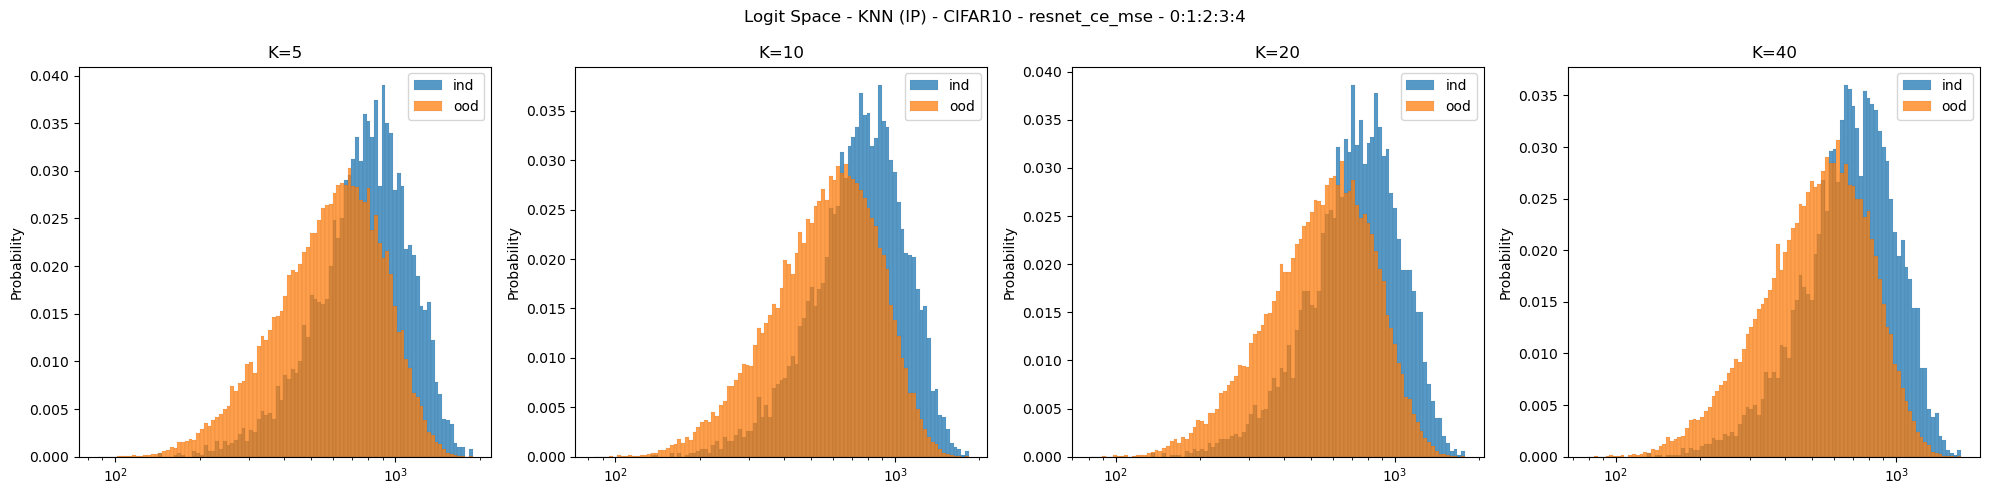

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

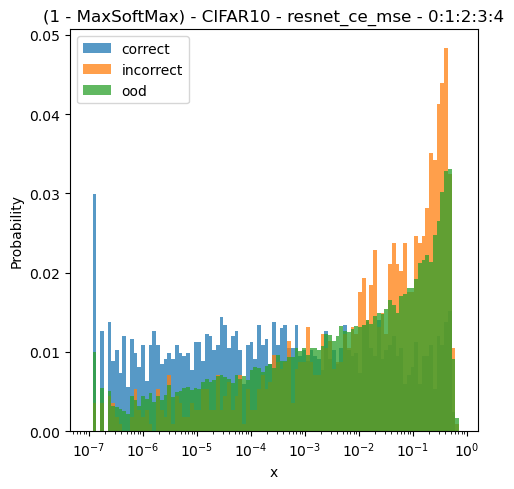

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

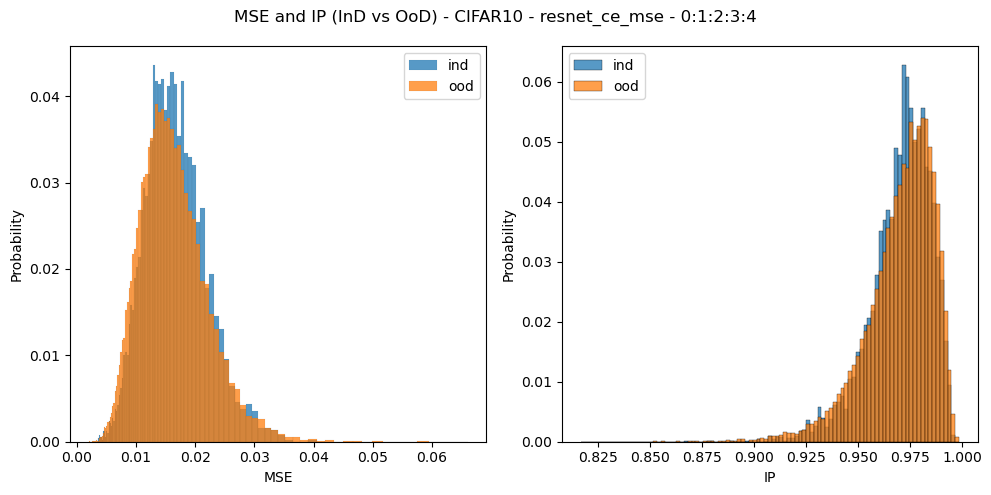

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()